<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/pretrained_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import random 

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm==0.4.5 pytorch-lightning optuna

     |████████████████████████████████| 287 kB 6.8 MB/s 
     |████████████████████████████████| 582 kB 48.3 MB/s 
     |████████████████████████████████| 308 kB 55.0 MB/s 
     |████████████████████████████████| 408 kB 49.3 MB/s 
     |████████████████████████████████| 136 kB 52.0 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 81 kB 7.0 MB/s 
     |████████████████████████████████| 210 kB 80.7 MB/s 
     |████████████████████████████████| 271 kB 69.7 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 146 kB 70.6 MB/s 
     |████████████████████████████████| 113 kB 77.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=111

In [466]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import optuna
from drive.MyDrive.MIT.HODL.ssast.src.models.ast_models import ASTModel
import matplotlib.pyplot as plt 
import librosa

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchaudio import transforms

In [ ]:
#!wget -O mel_spec_datadict https://www.dropbox.com/s/nrebpbe5g97sptu/mel_spec_datadict?dl=0
!wget -O mel_spec_datadict_all https://www.dropbox.com/s/e9l6xid06080g6z/mel_spec_datadict_all?dl=0

--2022-05-03 19:01:00--  https://www.dropbox.com/s/e9l6xid06080g6z/mel_spec_datadict_all?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e9l6xid06080g6z/mel_spec_datadict_all [following]
--2022-05-03 19:01:01--  https://www.dropbox.com/s/raw/e9l6xid06080g6z/mel_spec_datadict_all
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc98b85cb1d4ff44bbdb56045309.dl.dropboxusercontent.com/cd/0/inline/BkmL_3S92VTIc_LeXdXFVTHMFN5BNi2s2HQAQh5OkfYLK6ZpVSf8SdbyOBnQFEGcUFUpGYFLEvGfWGYIBcmM-oyXOSPU-g4CfM9S9BsEfJo17GyrXjhWHsml6oTWVLzsEV3bAthrJxzbcXyh12EVNYDdehTrCizp7grLeTm8pjgSyg/file# [following]
--2022-05-03 19:01:01--  https://uc98b85cb1d4ff44bbdb56045309.dl.dropboxusercontent.com/cd/0/inline/BkmL_3S92VTIc_LeXdXFVTHMFN5BNi2s2HQA

In [ ]:
with open('mel_spec_datadict_all', 'rb') as f:
    mel_spec_datadict = pickle.load(f)
# with open('mel_spec_datadict_all', 'rb') as f:

In [ ]:
!wget -O raw_datadict_all https://www.dropbox.com/s/yfi64jhyk9wzv6l/raw_datadict_all?dl=0

--2022-05-03 19:03:56--  https://www.dropbox.com/s/yfi64jhyk9wzv6l/raw_datadict_all?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yfi64jhyk9wzv6l/raw_datadict_all [following]
--2022-05-03 19:03:57--  https://www.dropbox.com/s/raw/yfi64jhyk9wzv6l/raw_datadict_all
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ca114251c79be673614dd4fff.dl.dropboxusercontent.com/cd/0/inline/Bkl3SjPYcrFcFRzQhSj3srZU_L7jkrvbOMuf8vAVjzet2H3R818eE8yw34APtpO4MbTRuuagCx1YQ5eivHRkBwOmgmZtmjSoWIPvz2WQMjfvzfDoxfDfmpLX93h-994kSNqX3i6sEzRTs73-DQ-Qc4J0iDuhpnN_OhkJu-NJy2a6rA/file# [following]
--2022-05-03 19:03:57--  https://uc1ca114251c79be673614dd4fff.dl.dropboxusercontent.com/cd/0/inline/Bkl3SjPYcrFcFRzQhSj3srZU_L7jkrvbOMuf8vAVjzet2H3R81

In [ ]:
with open('raw_datadict_all', 'rb') as f:
  raw_datadict_all = pickle.load(f)

In [625]:
X_train, y_train = mel_spec_datadict['X_train']
X_val, y_val = mel_spec_datadict['X_holdout']
X_test, y_test = mel_spec_datadict['X_test']

X_train = mel_spec_datadict['X_train'][0]
X_val = mel_spec_datadict['X_holdout'][0]
X_test = mel_spec_datadict['X_test'][0]

y_train = raw_datadict_all['X_train'][0]['popGreaterThan50']
y_val = raw_datadict_all['X_holdout'][0]['popGreaterThan50']
y_test = raw_datadict_all['X_test'][0]['popGreaterThan50']
y_train2 = raw_datadict_all['X_train'][0]['popularity']
y_val2 = raw_datadict_all['X_holdout'][0]['popularity']
y_test2 = raw_datadict_all['X_test'][0]['popularity']
y_train3 = (raw_datadict_all['X_train'][0]['popularity'] >= 39).astype(int)
y_val3 = (raw_datadict_all['X_holdout'][0]['popularity'] >= 39).astype(int)
y_test3 = (raw_datadict_all['X_test'][0]['popularity'] >= 39).astype(int)

#focusing on top5 artists 
top5_artists = raw_datadict_all['X_train'][0].groupby("artists", as_index = False).count().sort_values("duration_ms", ascending = False)['artists'][:5]
top5_artists = top5_artists.values

X_train_artists = X_train[raw_datadict_all['X_train'][0]['artists'].isin(top5_artists),:,:,:]
X_val_artists = X_val[raw_datadict_all['X_holdout'][0]['artists'].isin(top5_artists),:,:,:]
X_test_artists = X_test[raw_datadict_all['X_test'][0]['artists'].isin(top5_artists),:,:,:]

y_train_artists = raw_datadict_all['X_train'][1][raw_datadict_all['X_train'][0]['artists'].isin(top5_artists)]
y_val_artists = raw_datadict_all['X_holdout'][1][raw_datadict_all['X_holdout'][0]['artists'].isin(top5_artists)]
y_test_artists = raw_datadict_all['X_test'][1][raw_datadict_all['X_test'][0]['artists'].isin(top5_artists)]

In [ ]:
pl.seed_everything(0, workers=True)

Global seed set to 0


0

In [431]:
# hyperparameters
NB_EPOCHS = 20
PATIENCE = 10
DOWNSAMPLING_FACTOR = 10
INPUT_TDIM = int(X_train.shape[2] / DOWNSAMPLING_FACTOR)
INPUT_FDIM = X_train.shape[1]
TASK = 'classification'
MONITOR = 'val_loss' #'val_loss'
MONITOR_HYPERPARAM = 'val_acc'

BATCH_SIZE = 32
LEARNING_RATE = 3e-4
DROPOUT_PROB = 0.0
USE_CLS_POOLING = True
NB_LAYERS_TO_FREEZE = 12
GRAD_ACC = 1

In [432]:
# downsampling
indices_to_isolate = [k * DOWNSAMPLING_FACTOR for k in range(INPUT_TDIM)]
len(indices_to_isolate)

129

In [654]:
# data
X_train = X_train_artists
X_val = X_val_artists
X_test = X_test_artists

X_train_downsampled = X_train[:,:,indices_to_isolate,:]
X_train_normalized = (X_train_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)
X_val_downsampled = X_val[:,:,indices_to_isolate,:]
X_val_normalized = (X_val_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)
X_test_downsampled = X_test[:,:,indices_to_isolate,:]
X_test_normalized = (X_test_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)

X_train_ = torch.from_numpy(X_train_normalized).to(torch.float16).squeeze(-1)
X_val_ = torch.from_numpy(X_val_normalized).to(torch.float16).squeeze(-1)
X_test_ = torch.from_numpy(X_test_normalized).to(torch.float16).squeeze(-1)
# y_train_ = torch.from_numpy(y_train.values).to(torch.float16)
# y_val_ = torch.from_numpy(y_val.values).to(torch.float16)
# y_test_ = torch.from_numpy(y_test.values).to(torch.float16)
y_train_ = torch.tensor(pd.get_dummies(y_train_artists).to_numpy()).squeeze()
y_val_ = torch.tensor(pd.get_dummies(y_val_artists).to_numpy()).squeeze()
y_test_ = torch.tensor(pd.get_dummies(y_test_artists).to_numpy()).squeeze()

def transform_spec(spec):
  if np.random.random() <= 0.6:
    p = np.random.random()
    if p  <= 0.6:
      mask_param = 40
      transform = nn.Sequential(transforms.FrequencyMasking(freq_mask_param=mask_param), 
                                transforms.TimeMasking(time_mask_param=mask_param)).to(device)
      return transform(spec.to(device))
    elif 0.6 <= p <= 1:
      transform = transforms.Fade(fade_in_len = 50, fade_out_len = 50)
      return transform(spec.to(device))
    else:
      transform = transforms.PitchShift(sample_rate = 10, n_steps = 10, n_fft=128).to(device)
      return transform(spec.to(device))
  else:
    return spec

class SpectDataset(torch.utils.data.TensorDataset):
  # def __getitem__(self, index):
  #       return tuple(tensor[index] for tensor in self.tensors)
  def __getitem__(self, index):
    return tuple(transform_spec(tensor.to(device))[index] if len(tensor.shape) == 3 else tensor.to(device)[index]
                 for tensor in self.tensors)
    
train = SpectDataset(X_train_, y_train_)
val = torch.utils.data.TensorDataset(X_val_, y_val_)
test = torch.utils.data.TensorDataset(X_test_, y_test_)
# loaders
train_loader = torch.utils.data.DataLoader(train, sampler=torch.utils.data.RandomSampler(train), batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val, sampler=torch.utils.data.SequentialSampler(val), batch_size=BATCH_SIZE*2)
test_loader = torch.utils.data.DataLoader(test, sampler=torch.utils.data.SequentialSampler(test), batch_size=BATCH_SIZE*2)

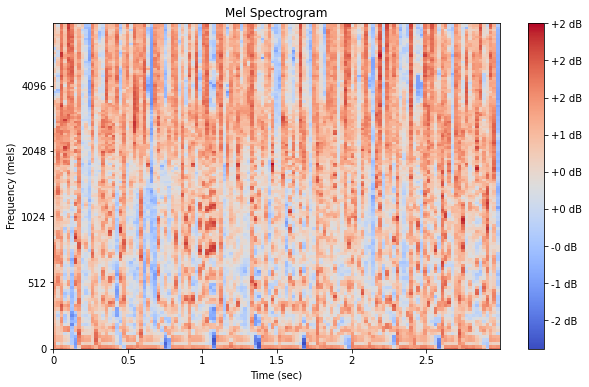

In [655]:
x = X_train_.to(device) 
#x = torch.tensor(mel_spec_datadict['X_holdout'][0][1]).to(device)
#transform = transforms.FrequencyMasking(freq_mask_param=40)
transform = transforms.PitchShift(sample_rate = 10, n_steps = 10, n_fft=128).to(device)

#nn.Sequential(transforms.FrequencyMasking(freq_mask_param=0.5), 
#                                transforms.TimeMasking(time_mask_param=0.5)).to(device)

fig, ax = plt.subplots(figsize=(10,6))
img = specshow(x[0,:,:].cpu().numpy(), x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

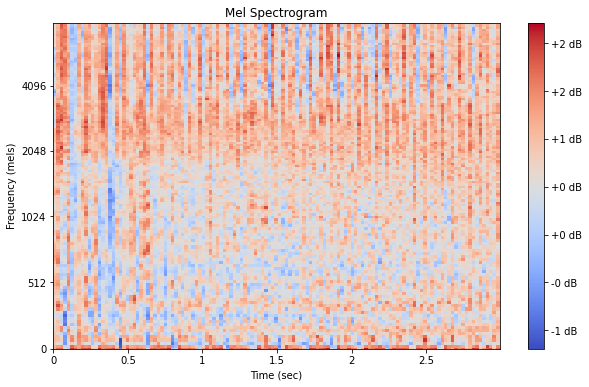

In [606]:
x = transform(x[0,:,:].cuda())
fig, ax = plt.subplots(figsize=(10,6))
img = specshow(x.cpu().numpy(), x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [465]:
x.shape

(128, 1292, 1)

In [656]:
class CustomASTModel(pl.LightningModule):

  def __init__(
      self,
      input_fdim=INPUT_FDIM,
      input_tdim=INPUT_TDIM,
      use_small=True,
      use_cls_pooling=USE_CLS_POOLING,
      dropout_prob=DROPOUT_PROB,
      task='classification',
      regression_threshold=1.0,
      nb_layers_to_freeze=NB_LAYERS_TO_FREEZE,
      lr=LEARNING_RATE
  ):
    super().__init__()
    self.lr = lr
    self.dropout_prob = dropout_prob
    self.regression_threshold = regression_threshold

    if use_cls_pooling:
      self.pooling_type = 'ft_cls'
    else:
      self.pooling_type = 'ft_avgtok'

    assert(task in ['classification','regression', 'artists'])
    self.task = task

    if use_small:
      self.model = ASTModel(
          label_dim=1,    # no impact
          fshape=16, 
          tshape=16, 
          fstride=10, 
          tstride=10,
          input_fdim=input_fdim, 
          input_tdim=input_tdim, 
          model_size='small',
          pretrain_stage=False, 
          load_pretrained_mdl_path=(
              '/content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth'
          )
      )
    else:
       self.model = ASTModel(
          label_dim=1,
          fshape=16, 
          tshape=16, 
          fstride=10, 
          tstride=10,
          input_fdim=input_fdim, 
          input_tdim=input_tdim, 
          model_size='base',
          pretrain_stage=False, 
          load_pretrained_mdl_path=(
              '/content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Base-Patch-400.pth'
          )
       ) 
    self.cls_shape = self.model.v.blocks[-1].mlp.fc2.out_features
    mlp_head = nn.Sequential(
        nn.LayerNorm(self.cls_shape),
        nn.Linear(in_features=self.cls_shape, out_features=int(self.cls_shape / 2), bias=True),
        nn.Dropout(self.dropout_prob),
        nn.Linear(in_features=int(self.cls_shape / 2), out_features=5 if self.task == 'artists' else 1,
                  bias=True),
    )
    self.model.mlp_head = mlp_head

    if nb_layers_to_freeze > 0:
      assert(nb_layers_to_freeze-1 in range(len(self.model.v.blocks)))
      for i,block in enumerate(self.model.v.blocks):
        if i < nb_layers_to_freeze:
          for param in block.parameters():
            param.requires_grad = False
        else:
          break


  def forward(self, x):
    h = self.model(x, task=self.pooling_type)
    return x


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer


  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x = x.cuda(0)
    y = y.cuda(0).unsqueeze(1)
    y_hat = self.model(x, task=self.pooling_type)

    if self.task == 'classification':
      loss = F.binary_cross_entropy_with_logits(y_hat, y)
      sigmoid = torch.sigmoid(y_hat)
      auc = roc_auc_score(y.cpu().detach().numpy(), sigmoid.cpu().detach().numpy())
      threshold = torch.tensor([0.5]).to(torch.float16).cuda(0)
      results = (sigmoid > threshold).to(torch.float16)
      acc = accuracy_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      f1 = f1_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('train_auc', auc)
      self.log('train_acc', acc)
      self.log('train_f1', acc)

    elif self.task == 'regression':
      # y_hat = torch.relu(y_hat)   # we are trying to predict something positive so using relu makes sense
      y_hat = torch.clip(y_hat, min=np.float16(0.0), max=np.float16(self.regression_threshold))
      loss = F.mse_loss(y_hat, y)
      rmse = np.sqrt(mean_squared_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy()))
      mae = mean_absolute_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      self.log('train_rmse', rmse)
      self.log('train_mae', mae)
      self.log('train_r2', r2)

    elif self.task == 'artists':
      y = y.squeeze().float()
      criterion = nn.CrossEntropyLoss()
      loss = criterion(y_hat, y)
      results = torch.argmax(y_hat, axis = 1)
      y_int = torch.argmax(y, axis = 1)
      acc = accuracy_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      #f1 = f1_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('train_acc', acc)
      self.log('train_f1', acc)

    self.log('train_loss', loss)
    return loss


  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x = x.cuda(0)
    y = y.cuda(0).unsqueeze(1)
    y_hat = self.model(x, task=self.pooling_type)

    if self.task == 'classification':
      loss = F.binary_cross_entropy_with_logits(y_hat, y)
      sigmoid = torch.sigmoid(y_hat)
      auc = roc_auc_score(y.cpu().detach().numpy(), sigmoid.cpu().detach().numpy())
      threshold = torch.tensor([0.5]).to(torch.float16).cuda(0)
      results = (sigmoid > threshold).to(torch.float16)
      acc = accuracy_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      f1 = f1_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('val_auc', auc)
      self.log('val_acc', acc)
      self.log('val_f1', acc)

    elif self.task == 'regression':
      # y_hat = torch.relu(y_hat)   # we are trying to predict something positive so using relu makes sense
      y_hat = torch.clip(y_hat, min=np.float16(0.0), max=np.float16(self.regression_threshold))
      loss = F.mse_loss(y_hat, y)
      rmse = np.sqrt(mean_squared_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy()))
      mae = mean_absolute_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      self.log('val_rmse', rmse)
      self.log('val_mae', mae)
      self.log('val_r2', r2)

    elif self.task == 'artists':
      y = y.squeeze().float()
      criterion = nn.CrossEntropyLoss()
      loss = criterion(y_hat, y)
      results = torch.argmax(y_hat, axis = 1)
      y_int = torch.argmax(y, axis = 1)
      acc = accuracy_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      #f1 = f1_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('val_acc', acc)
      self.log('val_f1', acc)

    self.log('val_loss', loss)

# some simple tests

In [657]:
# model
model = CustomASTModel(task = "artists")

now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


In [658]:
# training
early_stop_callback = EarlyStopping(
    monitor=MONITOR, 
    min_delta=0.00, 
    patience=PATIENCE, 
    verbose=True, 
    mode=(
        "max" if MONITOR in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
    )
)
trainer = pl.Trainer(
    gpus=1,
    limit_train_batches=1.0, 
    accumulate_grad_batches=GRAD_ACC,
    precision=16, 
    max_epochs=NB_EPOCHS, 
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
1.0 M     Trainable params
21.3 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.676


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.617


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.608


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.539


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.531


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.527


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.504


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [661]:
val_results = trainer.validate(model,  test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.35714285714285715
         val_f1             0.35714285714285715
        val_loss            1.5294421911239624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

# hyperparameter tuning

In [618]:
def objective(trial): 

  BATCH_SIZE = trial.suggest_int("batch_size", 1, 4)
  BATCH_SIZE *= 16
  LEARNING_RATE = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  DROPOUT_PROB = trial.suggest_float("dropout_prob", 0.0, 0.5)
  USE_CLS_POOLING = trial.suggest_categorical("use_cls_pooling", [True, False])
  NB_LAYERS_TO_FREEZE = trial.suggest_int("nb_layers_to_freeze", 0, 12)
  GRAD_ACC = trial.suggest_int("grad_acc", 1, 2)

  train_loader = torch.utils.data.DataLoader(train, sampler=torch.utils.data.RandomSampler(train), batch_size=BATCH_SIZE)
  val_loader = torch.utils.data.DataLoader(val, sampler=torch.utils.data.SequentialSampler(val), batch_size=BATCH_SIZE)
  test_loader = torch.utils.data.DataLoader(test, sampler=torch.utils.data.SequentialSampler(test), batch_size=BATCH_SIZE)

  model = CustomASTModel(
      use_cls_pooling=USE_CLS_POOLING,
      dropout_prob=DROPOUT_PROB,
      nb_layers_to_freeze=NB_LAYERS_TO_FREEZE,
      lr=LEARNING_RATE,
      task = "artists"  
  )

  early_stop_callback = EarlyStopping(
      monitor=MONITOR, 
      min_delta=0.00, 
      patience=PATIENCE, 
      verbose=True, 
      mode=(
          "max" if MONITOR in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
      )
  )

  checkpoint_callback = ModelCheckpoint(
      save_top_k=1, 
      monitor=MONITOR_HYPERPARAM, 
      mode=(
          "max" if MONITOR_HYPERPARAM in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
      )
  )

  trainer = pl.Trainer(
      gpus=1,
      limit_train_batches=1.0, 
      accumulate_grad_batches=GRAD_ACC,
      precision=16, 
      max_epochs=NB_EPOCHS, 
      callbacks=[early_stop_callback, checkpoint_callback],
      enable_checkpointing=True,
      log_every_n_steps=16,
      # enable_progress_bar=False
  )

  trainer.fit(model, train_loader, val_loader)

  # val_results = trainer.validate(model, val_loader)
  
  # return val_results[0][MONITOR_HYPERPARAM]
  return checkpoint_callback.best_model_score

In [662]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, gc_after_trial=True)

[I 2022-05-04 05:06:28,803] A new study created in memory with name: no-name-d2a1434b-b221-494f-9e9b-666bd7064d76


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
11.6 M    Trainable params
10.6 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.577


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.571


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.565


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.556


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.552


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.548


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.545


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.542


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:06:55,808] Trial 0 finished with value: 0.3225806451612903 and parameters: {'batch_size': 3, 'learning_rate': 3.1019062336288775e-05, 'dropout_prob': 0.4709145003916218, 'use_cls_pooling': True, 'nb_layers_to_freeze': 6, 'grad_acc': 1}. Best is trial 0 with value: 0.3225806451612903.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.522


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.435 >= min_delta = 0.0. New best score: 3.087


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.480 >= min_delta = 0.0. New best score: 2.606


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 2.482


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.685 >= min_delta = 0.0. New best score: 1.797


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.717


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.670


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.660


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.644


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.630


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.624


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.622


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.619


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:07:24,466] Trial 1 finished with value: 0.22580645161290322 and parameters: {'batch_size': 3, 'learning_rate': 0.005531406458329446, 'dropout_prob': 0.3538205583606148, 'use_cls_pooling': True, 'nb_layers_to_freeze': 0, 'grad_acc': 2}. Best is trial 0 with value: 0.3225806451612903.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
17.0 M    Trainable params
5.3 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.586


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.567


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.555


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.539


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:07:58,622] Trial 2 finished with value: 0.3870967741935484 and parameters: {'batch_size': 1, 'learning_rate': 1.5564127084513095e-05, 'dropout_prob': 0.30365893761256274, 'use_cls_pooling': True, 'nb_layers_to_freeze': 3, 'grad_acc': 1}. Best is trial 2 with value: 0.3870967741935484.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.621


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.576


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.565


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.561


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.555


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.544


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.511


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.484


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:08:30,256] Trial 3 finished with value: 0.3870967741935484 and parameters: {'batch_size': 4, 'learning_rate': 0.00010524256522509845, 'dropout_prob': 0.3410866162741883, 'use_cls_pooling': False, 'nb_layers_to_freeze': 0, 'grad_acc': 2}. Best is trial 2 with value: 0.3870967741935484.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
17.0 M    Trainable params
5.3 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.599


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.593


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.587


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.579


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.575


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.559


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.544


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.536


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.534


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.529


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.526


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.515


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.509


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.498
[I 2022-05-04 05:09:03,792] Trial 4 finished with value: 0.41935483870967744 and parameters: {'batch_size': 3, 'learning_rate': 4.530924776897969e-05, 'dropout_prob': 0.30534865875904976, 'use_cls_pooling': False, 'nb_layers_to_freeze': 3, 'grad_acc': 2}. Best is trial 4 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.600


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.593


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.559


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.558


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.542


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.493


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.459


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:09:37,624] Trial 5 finished with value: 0.41935483870967744 and parameters: {'batch_size': 2, 'learning_rate': 3.904805725753852e-05, 'dropout_prob': 0.4910227228130508, 'use_cls_pooling': True, 'nb_layers_to_freeze': 0, 'grad_acc': 1}. Best is trial 4 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.652


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.625


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.601


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.589


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.567


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:10:12,635] Trial 6 finished with value: 0.4838709677419355 and parameters: {'batch_size': 1, 'learning_rate': 0.0007881795847438402, 'dropout_prob': 0.32161389001890733, 'use_cls_pooling': False, 'nb_layers_to_freeze': 0, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
13.4 M    Trainable params
8.9 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.673


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.622


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.609


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.607


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.596


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:10:41,723] Trial 7 finished with value: 0.3548387096774194 and parameters: {'batch_size': 4, 'learning_rate': 0.0001528864582003107, 'dropout_prob': 0.07442121233816934, 'use_cls_pooling': True, 'nb_layers_to_freeze': 5, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.704


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.681


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.680


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.653


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.637


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.637


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.636


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.634


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.625


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:11:12,446] Trial 8 finished with value: 0.3548387096774194 and parameters: {'batch_size': 2, 'learning_rate': 0.0012681583208000154, 'dropout_prob': 0.019771635167650403, 'use_cls_pooling': True, 'nb_layers_to_freeze': 0, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
11.6 M    Trainable params
10.6 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.632


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.609


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.601


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.597


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.596


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.595


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.592


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.590


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.588


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.583


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.579


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.575


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.571


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.568


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.566


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.562


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.561


Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:11:39,547] Trial 9 finished with value: 0.3870967741935484 and parameters: {'batch_size': 3, 'learning_rate': 1.67316593501716e-05, 'dropout_prob': 0.3157255534188067, 'use_cls_pooling': True, 'nb_layers_to_freeze': 6, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
4.6 M     Trainable params
17.7 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.758


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 1.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.633


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.602


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.557


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.550


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.550. Signaling Trainer to stop.
[I 2022-05-04 05:12:06,167] Trial 10 finished with value: 0.41935483870967744 and parameters: {'batch_size': 1, 'learning_rate': 0.0008454317592596677, 'dropout_prob': 0.18753558461769843, 'use_cls_pooling': False, 'nb_layers_to_freeze': 10, 'grad_acc': 1}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
17.0 M    Trainable params
5.3 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.789


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 1.623


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.612


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.595


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.529


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:12:36,726] Trial 11 finished with value: 0.3870967741935484 and parameters: {'batch_size': 2, 'learning_rate': 0.0006202140913088706, 'dropout_prob': 0.22611385544144905, 'use_cls_pooling': False, 'nb_layers_to_freeze': 3, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
17.0 M    Trainable params
5.3 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.008


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 1.798


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 1.668


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.644


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.644


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.642


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.638


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:13:08,219] Trial 12 finished with value: 0.25806451612903225 and parameters: {'batch_size': 1, 'learning_rate': 0.0036056532658406176, 'dropout_prob': 0.4063112316622329, 'use_cls_pooling': False, 'nb_layers_to_freeze': 3, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
6.3 M     Trainable params
16.0 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.648


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.613


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.602


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.581


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.557


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.520


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.519


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.489


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 05:13:34,841] Trial 13 finished with value: 0.45161290322580644 and parameters: {'batch_size': 3, 'learning_rate': 0.00023953052103042064, 'dropout_prob': 0.15338951950774618, 'use_cls_pooling': False, 'nb_layers_to_freeze': 9, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
4.6 M     Trainable params
17.7 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.611


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.605


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.595


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.566


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.547


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.521


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.509


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.507
[I 2022-05-04 05:14:00,022] Trial 14 finished with value: 0.41935483870967744 and parameters: {'batch_size': 2, 'learning_rate': 0.0002455846197383154, 'dropout_prob': 0.14631917856357318, 'use_cls_pooling': False, 'nb_layers_to_freeze': 10, 'grad_acc': 2}. Best is trial 6 with value: 0.4838709677419355.


In [663]:
study.best_trial

FrozenTrial(number=6, values=[0.4838709677419355], datetime_start=datetime.datetime(2022, 5, 4, 5, 9, 38, 12423), datetime_complete=datetime.datetime(2022, 5, 4, 5, 10, 12, 634580), params={'batch_size': 1, 'learning_rate': 0.0007881795847438402, 'dropout_prob': 0.32161389001890733, 'use_cls_pooling': False, 'nb_layers_to_freeze': 0, 'grad_acc': 2}, distributions={'batch_size': IntUniformDistribution(high=4, low=1, step=1), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-05), 'dropout_prob': UniformDistribution(high=0.5, low=0.0), 'use_cls_pooling': CategoricalDistribution(choices=(True, False)), 'nb_layers_to_freeze': IntUniformDistribution(high=12, low=0, step=1), 'grad_acc': IntUniformDistribution(high=2, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=TrialState.COMPLETE, value=None)

In [639]:
sorted(np.unique(list(raw_datadict_all["X_train"][0]['artists'])))

['"Why Don\'t We"',
 '24kGoldn',
 '88rising',
 'ATEEZ',
 'Above & Beyond',
 'Alec Benjamin',
 'Alicia Keys',
 'Alina Baraz',
 'Aries',
 'Armin van Buuren',
 'Ashnikko',
 'Ava Max',
 'BT',
 'BTS',
 'Bazzi',
 'Becky G',
 'Beyoncé',
 'Big Wild',
 'Bizarrap',
 'Blxst',
 'Brent Faiyaz',
 'Bruno Mars',
 'Bryson Tiller',
 'Burna Boy',
 'Cal Scruby',
 'Camila Cabello',
 'Camilo',
 'Cavetown',
 'Charli XCX',
 'Cheap Trick',
 'Cheat Codes',
 'Chris Brown',
 'Chris Webby',
 'Coldplay',
 'Crowded House',
 'DDG',
 'DJ Khaled',
 'Dalai Lama',
 'Dan + Shay',
 'Dax',
 'Dean Blunt',
 'Diet Cig',
 'Diplo',
 'Dj Scuff',
 'Doja Cat',
 'Dominic Fike',
 'Don Toliver',
 'Dua Lipa',
 'ENHYPEN',
 'Ed Sheeran',
 'Fabrizio De André',
 'Father John Misty',
 'Faye Webster',
 'Fer Palacio',
 'French Montana',
 'Future',
 'G-Eazy',
 'Gareth Emery',
 'Giveon',
 'Gucci Mane',
 'Gyllene Tider',
 'H.E.R.',
 'HONNE',
 'Hershy Langsam Productions',
 'ILLENIUM',
 'ITZY',
 'Iggy Azalea',
 'JP Saxe',
 'Joel Corry',
 'Johanne

In [385]:
'''
AUC: 0.7211533030146442
{
  'batch_size': 2, 
  'learning_rate': 7.83833546396864e-05, 
  'dropout_prob': 0.40324782505879203, 
  'use_cls_pooling': True, 
  'nb_layers_to_freeze': 8, 
  'grad_acc': 1
}
'''

"\nAUC: 0.7211533030146442\n{\n  'batch_size': 2, \n  'learning_rate': 7.83833546396864e-05, \n  'dropout_prob': 0.40324782505879203, \n  'use_cls_pooling': True, \n  'nb_layers_to_freeze': 8, \n  'grad_acc': 1\n}\n"

In [ ]:
pretrained_model_path = '/content/drive/MyDrive/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth'

In [ ]:
input_tdim = 128 # fine-tuning data length can be different with pretraining data length

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
ast_mdl = ASTModel(label_dim=1,
             fshape=16, tshape=16, fstride=10, tstride=10,
             input_fdim=128, input_tdim=input_tdim, model_size='small',
             pretrain_stage=False, load_pretrained_mdl_path=pretrained_model_path).to(device)

RuntimeError: ignored

In [ ]:
aast_mdl.v.blocks[0].attn.proj.weight.dtype

torch.float32

In [ ]:
n = ast_mdl.v.blocks[-1].mlp.fc2.out_features

ast_mdl.mlp_head = nn.Sequential(
    nn.LayerNorm(n),
    nn.Linear(in_features=n, out_features=1, bias=True),
    nn.Sigmoid()
)#.to(torch.float)

In [ ]:
x = torch.from_numpy(np.random.rand(8, 128, 128)).float()

In [ ]:
ast_mdl(x, task='ft_cls')

tensor([[0.3713],
        [0.3795],
        [0.3953],
        [0.3442],
        [0.3849],
        [0.3578],
        [0.3586],
        [0.3877]], grad_fn=<SigmoidBackward0>)